# Generating images with dimensionality reduction


The goal of this project is to explore different dimensionality reduction techniques and their ability to generate images from the reduced data. To achieve this, we will use the MNIST dataset, which consists of images of handwritten digits.

The first step will be to apply PCA to the MNIST dataset and reduce its dimensionality. We will then generate images using the PCA components and explore how well the images capture the original data.

Next, we will use UMAP as an alternative dimensionality reduction technique and generate images from the UMAP components. We will compare the images generated from PCA and UMAP and analyze the differences in how well they capture the original data.

To assess the quality and compare the generated images, we will use visual inspection. We will also explore how the hyperparameters of the dimensionality reduction algorithms affect the quality of the generated images.

In [1]:
import random

import umap
import numpy as np
import pandas as pd
import sklearn
from sklearn import datasets      
from sklearn import decomposition

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
X, y = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [3]:
X.shape

(70000, 784)

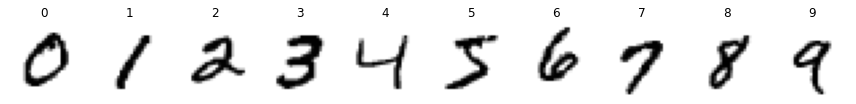

In [4]:
fig, axis = plt.subplots(1, 10, figsize=(12, 6))
for i, ax in enumerate(axis):
    ax.imshow(X[y == str(i)][0].reshape(28, 28), cmap='gray_r')
    ax.set_title(str(i))
    ax.axis('off')
plt.tight_layout()

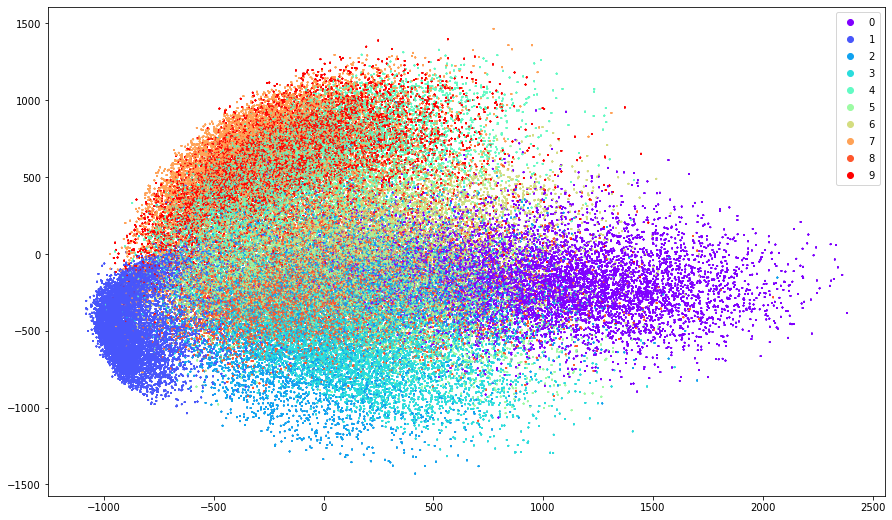

In [5]:
# PCA and representation of the numbers
plt.rcParams['figure.figsize'] = [15, 9]

pca = decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(X)
df = pd.DataFrame(X_pca, columns = ['principal component 1', 'principal component 2'])
df['label'] = y
df['label'] = df['label'].astype(int)

for number in df['label'].unique():
    scatter = plt.scatter(df['principal component 1'], df['principal component 2'], c=df['label'],s=0.4 , cmap='rainbow', label=number)
plt.legend(*scatter.legend_elements())
plt.show()

We observe that some numbers are quite separated from others, but others seem to be mixed with others. The classes 0, 1, and 2 are the ones that we can distinguish more easily. This is probably due to the unique form that these values have, so when performing PCA, they must have considerably more unique values compared to the other numbers.


In the previous graph, each point represents a sample in 2 dimensions. With PCA, it is possible to reverse the transformation so that, from each 2D point, the original image (784 dimensions) can be obtained again (approximately).

Therefore, it is possible to "generate" new images by randomly choosing points from the 2D plane, and asking the learned PCA model to invert the transformation to obtain the "theoretical" images that would have been projected to these points in the projected space.

In [6]:
max_col = np.amax(X_pca, axis=0)
min_col = np.amin(X_pca, axis=0)
print("Màxim component 1: {0}".format(max_col[0]))
print("Mínim component 1: {0}".format(min_col[0]))
print("Màxim component 2: {0}".format(max_col[1]))
print("Mínim component 2: {0}".format(min_col[1]))

Màxim component 1: 2383.9824729504703
Mínim component 1: -1081.1479176218438
Màxim component 2: 1464.4470271488553
Mínim component 2: -1428.8575393663095


In [7]:
# Component 1
comp1 = np.linspace(min_col[0], max_col[0], num=10)
comp1

array([-1081.14791762,  -696.13342978,  -311.11894194,    73.8955459 ,
         458.91003374,   843.92452158,  1228.93900943,  1613.95349727,
        1998.96798511,  2383.98247295])

In [8]:
# Component 2
comp2 = np.linspace(min_col[1], max_col[1], num=10)
comp2

array([-1428.85753937, -1107.3792542 ,  -785.90096903,  -464.42268386,
        -142.94439869,   178.53388648,   500.01217164,   821.49045681,
        1142.96874198,  1464.44702715])

With the two sequences of 10 values (one for each dimension of the projection plane), it is possible to combine the points of both sequences to generate 100 combinations (2D points) that divide the plane on which PCA has projected the samples.

We will now invert the transformation for each of the 100 points and visualize their associated image in a 10 x 10 matrix of images (trying to preserve their position in the projected space).

In [9]:
res = [[x,y] for x in comp1 for y in comp2]
len(res)
pca_inv = pca.inverse_transform(res)

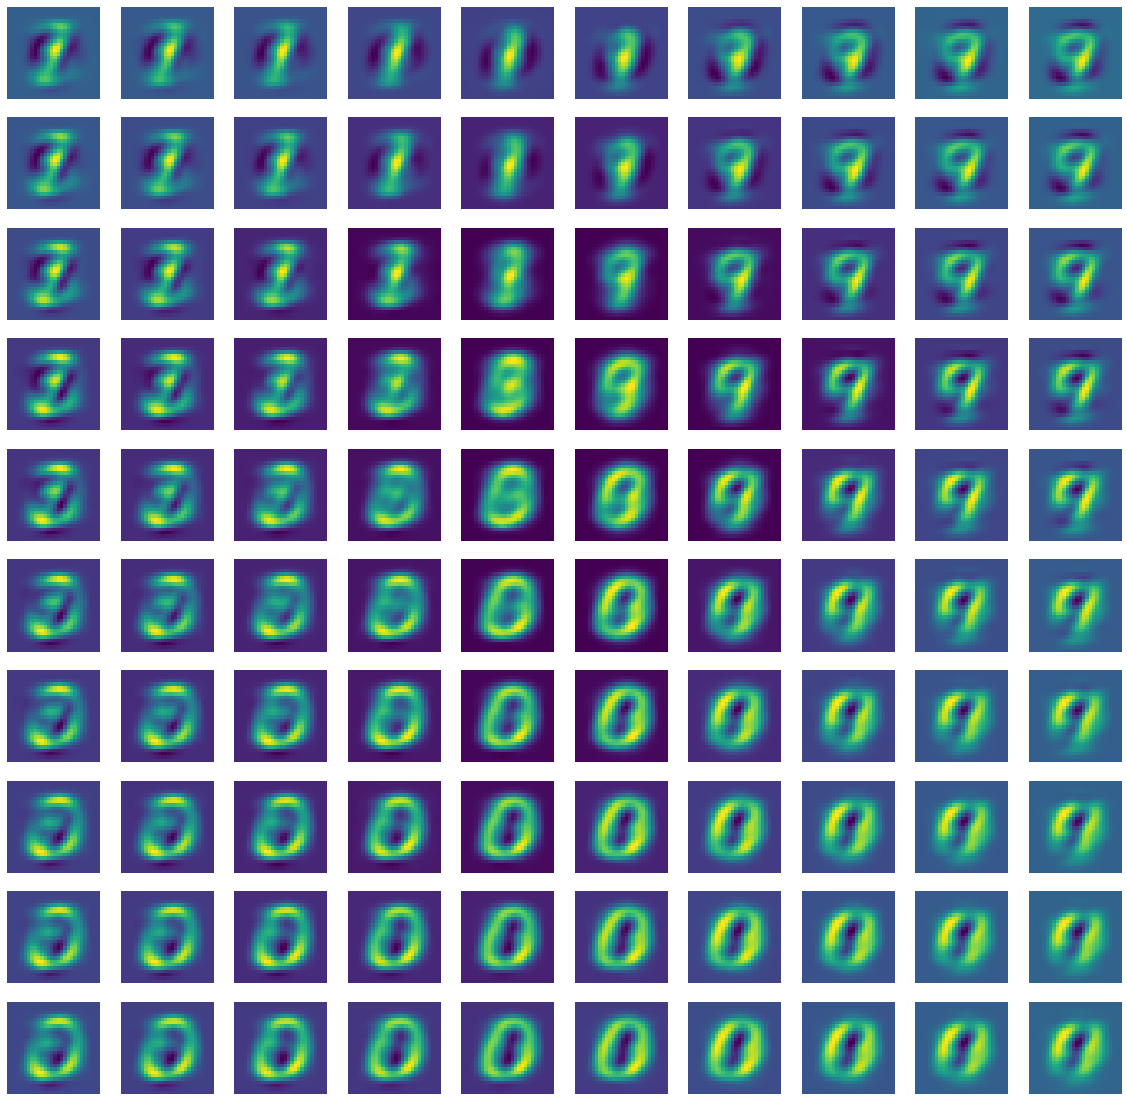

In [10]:
fig, axis = plt.subplots(10, 10, figsize=(20, 20))
axis = axis.ravel()

for i in range(100):
    axis[i].imshow(np.asmatrix(pca_inv[i]).reshape(28,28))
    axis[i].axis('off')


In the first row at the ends, we can recognize the number 1 and the number 9.
In the last row, we recognize the transition from the number 6 (inverted) -> 0 -> 8.

This is because by taking the extreme values, we are taking a "number" from the scatter plot we made before. Then, by permuting the values, we are basically generating different points around the scatter map, where each point represents the "transition/transformation/superposition" of numbers that have been scattered throughout the plot.

Therefore, if we start from a point and move forward, we gradually see the transformation of the value into another value, such as the fifth column where we see a value similar to 1, and as we move down the rows, we see that it transforms into 1 -> 3 -> 0.

In [11]:
import umap

umap1= umap.UMAP(random_state=42)
X_umap = umap1.fit_transform(X)

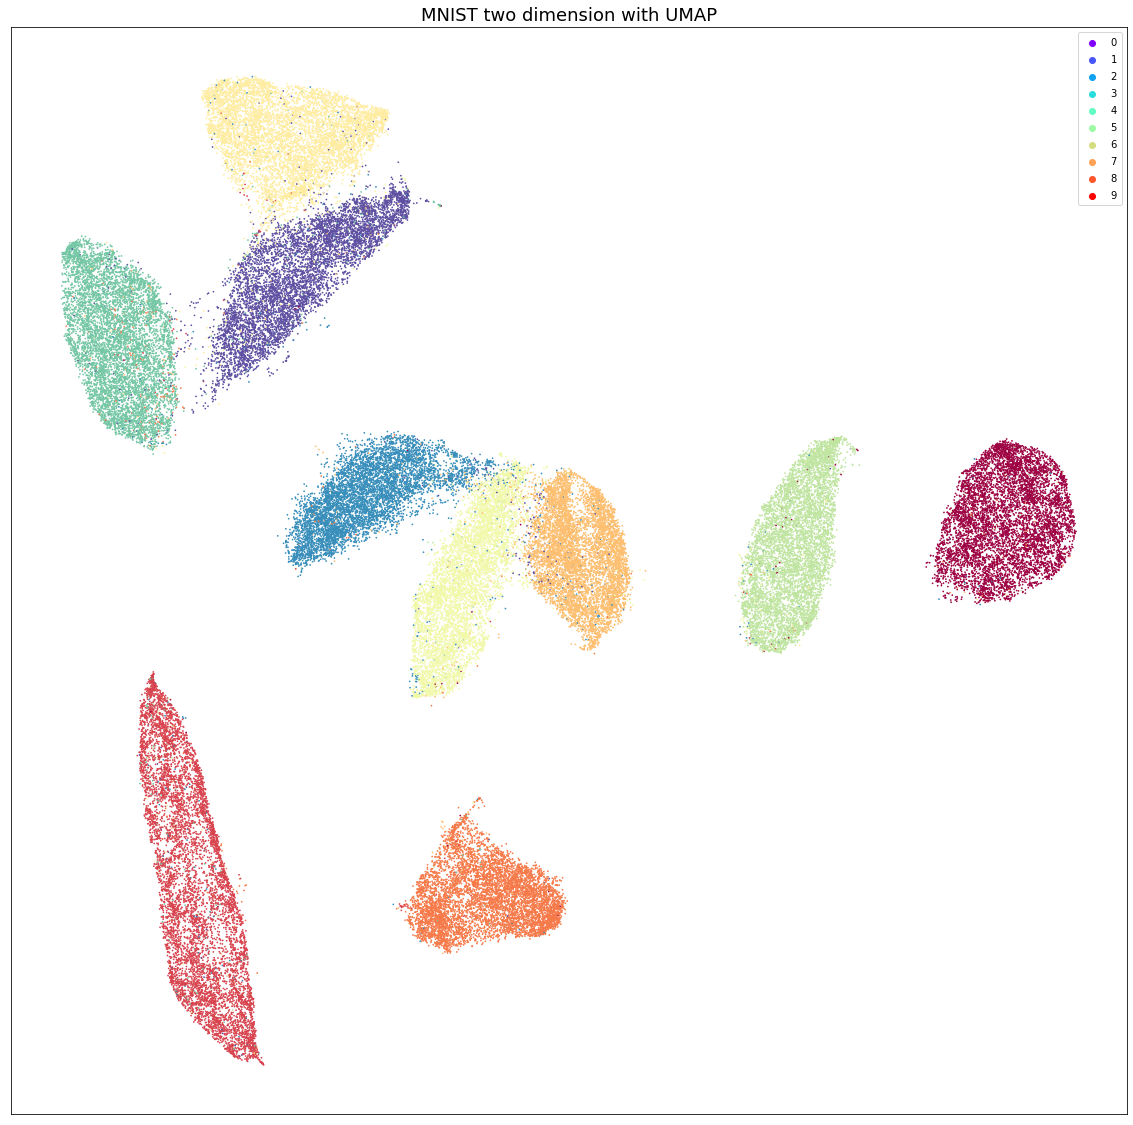

In [17]:
fig, ax = plt.subplots(figsize=(20, 20))
color = y.astype(int)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=color, cmap="Spectral", s=0.5, label=color)
plt.setp(ax, xticks=[], yticks=[])
plt.legend(*scatter.legend_elements())
plt.title("MNIST two dimension with UMAP", fontsize=18)

plt.show()

We observe that each number is much more separated compared to the values obtained previously, and each cluster of numbers is easily distinguishable.

This is due to the fact that UMAP works in a similar way to DBSCAN, where a minimum distance between neighbors and the number of neighbors found is specified, but it takes into account the global structure, distinguishing it from t-SNE.

This structure is created from the "fuzzy simplicial complex", where it can be represented with the weight of the probability that a point belongs to the same group or is connected to the same group. This means that as the minimum distance between two points increases, the probability of overlap between two radii of different points increases, making it consider two points as part of the same cluster. To avoid considering all points as the same cluster, the algorithm limits the minimum number of overlaps, so it only considers a point as part of a group when the number of overlapping radii is equal to or greater than the specified number.

In [13]:
max_col_umap = np.amax(X_umap, axis=0)
min_col_umap = np.amin(X_umap, axis=0)
print("Màxim component 1: {0}".format(max_col_umap[0]))
print("Mínim component 1: {0}".format(min_col_umap[0]))
print("Màxim component 2: {0}".format(max_col_umap[1]))
print("Mínim component 2: {0}".format(min_col_umap[1]))

Màxim component 1: 17.112035751342773
Mínim component 1: -5.7482123374938965
Màxim component 2: 15.420574188232422
Mínim component 2: -4.745725154876709


In [14]:
# Component 1
comp1_umap = np.linspace(min_col_umap[0], max_col_umap[0], num=10)
comp1_umap

array([-5.74821234, -3.20818477, -0.66815721,  1.87187036,  4.41189792,
        6.95192549,  9.49195306, 12.03198062, 14.57200819, 17.11203575])

In [15]:
# Component 2
comp2_umap = np.linspace(min_col_umap[1], max_col_umap[1], num=10)
comp2_umap

array([-4.74572515, -2.50502523, -0.2643253 ,  1.97637463,  4.21707455,
        6.45777448,  8.69847441, 10.93917433, 13.17987426, 15.42057419])

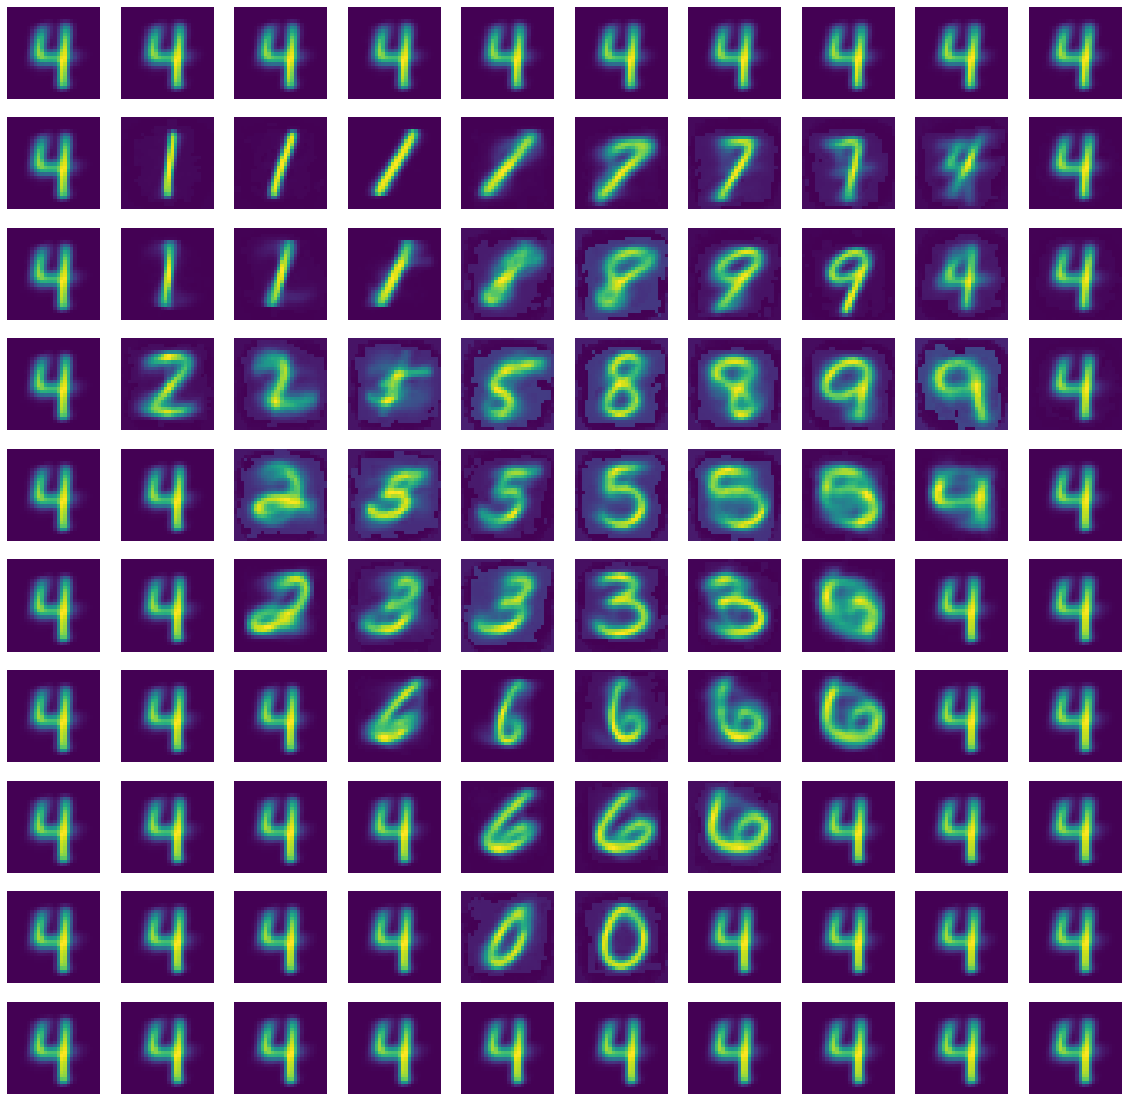

In [16]:
res_umap = [[x,tar] for x in comp1_umap for tar in comp2_umap]
len(res_umap)
umap_inv = umap1.inverse_transform(res_umap)

fig, axis = plt.subplots(10, 10, figsize=(20, 20))
axis = axis.ravel()

for i in range(100):
    axis[i].imshow(np.asmatrix(umap_inv[i]).reshape(28,28))
    axis[i].axis('off')

We can observe that the obtained result is much more defined compared to PCA, it should be noted that the model seems to be much more sensitive to the number 4 since as we can see in the results, number 4 is the value that is most defined.  
Returning to the other values, it is now possible to better differentiate the other numbers, they are much sharper compared to the same values obtained in PCA.